# Data Mining Assignment 5

## Task 1: Predictions for the test set

### Data Understanding and Data Preparation

In [174]:

import pandas as pd

# read in file with semicolon delimiter
from matplotlib import pyplot as plt

df_train_original = pd.read_csv('data/weather_train_data.csv')

# general info
print(df_train_original.head())
print(df_train_original.dtypes)
print('\nRows=' + str(len(df_train_original.index)) + '\n')
print('Columns=' + str(len(df_train_original.columns)) + '\n')



         Date       Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0  2009-09-25    Tuggeranong      3.4     19.7       0.0          NaN   
1  2014-02-02     Townsville     25.3     30.9      38.2         11.0   
2  2016-07-30  NorfolkIsland     14.0     19.2       0.0          NaN   
3  2009-06-14       Richmond      5.4     18.1       0.0          NaN   
4  2011-01-29        Walpole     19.0     24.8       7.8          NaN   

   Sunshine WindGustDir  WindGustSpeed WindDir9am  ... WindSpeed3pm  \
0       NaN          NW           57.0         NW  ...         24.0   
1       3.2         ESE           44.0          E  ...         13.0   
2       NaN         WSW           22.0         SW  ...         13.0   
3       NaN         NNE           28.0        NaN  ...          7.0   
4       NaN          SE           44.0          E  ...         17.0   

   Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  \
0         61.0         35.0       1012.9       1005.1    

In [175]:
df_train_original.describe(exclude=[object])

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,113254.000000,113507.000000,112660.000000,65230.000000,59604.000000,106361.000000,112663.000000,111674.000000,112350.000000,110914.000000,102630.000000,102652.000000,70958.000000,68213.000000,113036.000000,111619.000000
mean,12.189117,23.224917,2.371915,5.473963,7.619400,39.976617,14.016137,18.636164,68.815238,51.470941,1017.658942,1015.260929,4.436188,4.495741,16.986876,21.689802
std,6.400502,7.117415,8.536194,4.217432,3.784245,13.579409,8.905721,8.795008,19.072059,20.801685,7.095282,7.028610,2.888928,2.720098,6.490933,6.936576
min,-8.500000,-4.100000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,0.000000,980.500000,979.000000,0.000000,0.000000,-7.000000,-5.100000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.000000,1010.500000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,31.900000,48.100000,367.600000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1040.900000,1039.600000,8.000000,9.000000,40.200000,46.100000


In [176]:
df_train_original.describe(include=[object])

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday
count,113754,113754,106313,105740,110744,112660
unique,3411,49,16,16,16,2
top,2016-05-12,Canberra,W,N,SE,No
freq,46,2744,7798,9094,8576,87356


In [177]:
# merge predicted labels column
df_train_label_predictions = pd.read_csv('data/weather_train_label.csv', header=None)
df_train_label_predictions.columns = ['rain_prediction_correct']
df_train_original['rain_prediction_correct'] = df_train_label_predictions.iloc[:, 0]
df = df_train_original.copy()
df_train_original

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,rain_prediction_correct
0,2009-09-25,Tuggeranong,3.4,19.7,0.0,NaN,NaN,NW,57.0,NW,...,61.0,35.0,1012.9,1005.1,NaN,NaN,12.3,19.4,No,Yes
1,2014-02-02,Townsville,25.3,30.9,38.2,11.0,3.2,ESE,44.0,E,...,74.0,89.0,1005.7,1002.9,7.0,7.0,28.0,27.4,Yes,Yes
2,2016-07-30,NorfolkIsland,14.0,19.2,0.0,NaN,NaN,WSW,22.0,SW,...,55.0,51.0,1021.0,1017.9,8.0,NaN,17.1,18.6,No,No
3,2009-06-14,Richmond,5.4,18.1,0.0,NaN,NaN,NNE,28.0,NaN,...,90.0,69.0,1014.8,1011.6,NaN,NaN,7.4,14.2,No,No
4,2011-01-29,Walpole,19.0,24.8,7.8,NaN,NaN,SE,44.0,E,...,99.0,78.0,1013.2,1011.0,NaN,NaN,19.1,23.4,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113749,2015-10-16,Perth,6.8,22.5,0.0,3.8,12.0,SW,35.0,S,...,47.0,40.0,1023.9,1020.6,1.0,0.0,17.2,21.0,No,No
113750,2011-12-06,Richmond,12.1,18.4,0.4,13.6,NaN,SE,31.0,SSW,...,71.0,59.0,1020.6,1018.1,NaN,NaN,15.5,17.2,No,No
113751,2011-03-25,Sydney,17.7,26.7,0.0,8.8,8.0,W,46.0,W,...,50.0,42.0,1007.8,1008.7,NaN,NaN,20.5,24.8,No,No
113752,2011-08-08,SalmonGums,9.4,16.1,2.8,NaN,NaN,W,33.0,NNW,...,91.0,84.0,NaN,NaN,NaN,NaN,11.2,15.4,Yes,Yes


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113754 entries, 0 to 113753
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Date                     113754 non-null  object 
 1   Location                 113754 non-null  object 
 2   MinTemp                  113254 non-null  float64
 3   MaxTemp                  113507 non-null  float64
 4   Rainfall                 112660 non-null  float64
 5   Evaporation              65230 non-null   float64
 6   Sunshine                 59604 non-null   float64
 7   WindGustDir              106313 non-null  object 
 8   WindGustSpeed            106361 non-null  float64
 9   WindDir9am               105740 non-null  object 
 10  WindDir3pm               110744 non-null  object 
 11  WindSpeed9am             112663 non-null  float64
 12  WindSpeed3pm             111674 non-null  float64
 13  Humidity9am              112350 non-null  float64
 14  Humi

In [179]:
# sort by date
df = df.sort_values(by=['Date', 'Location'])
df


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,rain_prediction_correct
5903,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes
78109,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes
80649,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes
10407,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes
106464,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79406,2017-06-25,Townsville,16.5,25.8,0.0,NaN,NaN,ESE,31.0,SE,...,61.0,53.0,1018.1,1015.7,8.0,8.0,22.4,24.6,No,No
112828,2017-06-25,WaggaWagga,-0.1,12.7,0.0,NaN,NaN,SSW,19.0,SSW,...,92.0,54.0,1020.8,1018.5,8.0,8.0,4.0,10.7,No,No
12946,2017-06-25,Walpole,9.3,15.4,7.4,NaN,NaN,SSW,20.0,WNW,...,100.0,70.0,1028.7,1026.7,NaN,NaN,9.7,14.6,Yes,No
54631,2017-06-25,Watsonia,7.9,13.0,0.0,2.8,3.8,NNW,39.0,N,...,68.0,69.0,1017.6,1015.3,7.0,7.0,9.0,11.7,No,No


In [180]:
categorical_features = [column_name for column_name in df.columns if df[column_name].dtype == 'O']
print("Number of Categorical Features: {}".format(len(categorical_features)))
print("Categorical Features: ", categorical_features)

Number of Categorical Features: 7
Categorical Features:  ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'rain_prediction_correct']


In [181]:
numerical_features = [column_name for column_name in df.columns if df[column_name].dtype != 'O']
print("Number of Numerical Features: {}".format(len(numerical_features)))
print("Numerical Features: ", numerical_features)

Number of Numerical Features: 16
Numerical Features:  ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [182]:
for each_feature in categorical_features:
    unique_values = len(df[each_feature].unique())
    print("Cardinality(no. of unique values) of {} are: {}".format(each_feature, unique_values))

Cardinality(no. of unique values) of Date are: 3411
Cardinality(no. of unique values) of Location are: 49
Cardinality(no. of unique values) of WindGustDir are: 17
Cardinality(no. of unique values) of WindDir9am are: 17
Cardinality(no. of unique values) of WindDir3pm are: 17
Cardinality(no. of unique values) of RainToday are: 3
Cardinality(no. of unique values) of rain_prediction_correct are: 2


In [183]:
# rearrange date
df['Date'] = pd.to_datetime(df['Date'])
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df.drop('Date', axis=1, inplace=True)
df

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,rain_prediction_correct,year,month,day
5903,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,NW,...,1015.0,7.0,7.0,14.4,23.6,No,Yes,2007,11,1
78109,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,W,...,1008.4,5.0,3.0,17.5,25.7,Yes,Yes,2007,11,2
80649,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,NNE,...,1007.2,8.0,7.0,15.4,20.2,Yes,Yes,2007,11,3
10407,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,W,...,1007.0,2.0,7.0,13.5,14.1,Yes,Yes,2007,11,4
106464,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,ESE,...,1018.5,7.0,7.0,11.1,15.4,Yes,No,2007,11,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79406,Townsville,16.5,25.8,0.0,NaN,NaN,ESE,31.0,SE,ENE,...,1015.7,8.0,8.0,22.4,24.6,No,No,2017,6,25
112828,WaggaWagga,-0.1,12.7,0.0,NaN,NaN,SSW,19.0,SSW,SSE,...,1018.5,8.0,8.0,4.0,10.7,No,No,2017,6,25
12946,Walpole,9.3,15.4,7.4,NaN,NaN,SSW,20.0,WNW,SSW,...,1026.7,NaN,NaN,9.7,14.6,Yes,No,2017,6,25
54631,Watsonia,7.9,13.0,0.0,2.8,3.8,NNW,39.0,N,N,...,1015.3,7.0,7.0,9.0,11.7,No,No,2017,6,25


In [184]:
# check null values
print('Number of NaN:''\n')
df.isna().sum()


Number of NaN:



Location                       0
MinTemp                      500
MaxTemp                      247
Rainfall                    1094
Evaporation                48524
Sunshine                   54150
WindGustDir                 7441
WindGustSpeed               7393
WindDir9am                  8014
WindDir3pm                  3010
WindSpeed9am                1091
WindSpeed3pm                2080
Humidity9am                 1404
Humidity3pm                 2840
Pressure9am                11124
Pressure3pm                11102
Cloud9am                   42796
Cloud3pm                   45541
Temp9am                      718
Temp3pm                     2135
RainToday                   1094
rain_prediction_correct        0
year                           0
month                          0
day                            0
dtype: int64

In [185]:
categorical_features = [column_name for column_name in df.columns if df[column_name].dtype == 'O']
cat_null_df = df[categorical_features].isnull().sum().to_frame('nulls').sort_values(by='nulls', ascending=False)
cat_null_df

,nulls
WindDir9am,8014
WindGustDir,7441
WindDir3pm,3010
RainToday,1094
Location,0
rain_prediction_correct,0


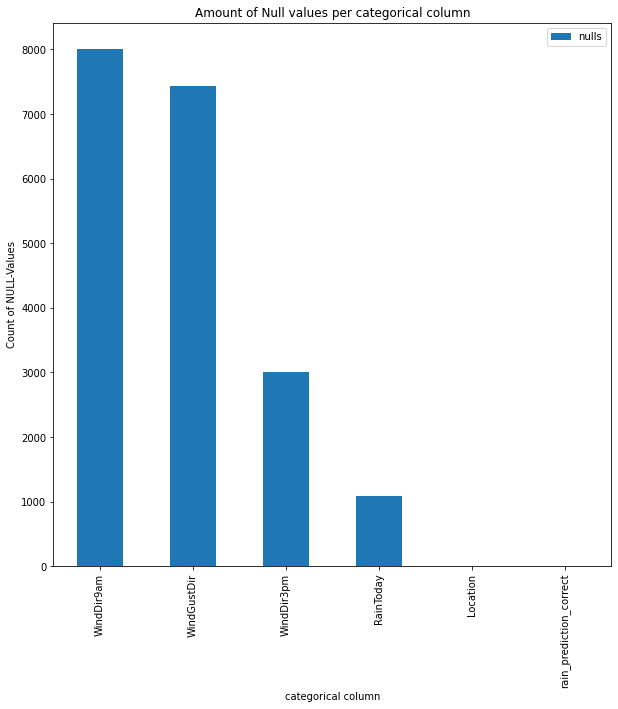

In [186]:
cat_null_df.plot(kind='bar', figsize=(10, 10))
plt.title('Amount of Null values per categorical column')
plt.suptitle('')
plt.xlabel('categorical column')
plt.ylabel('Count of NULL-Values')
plt.savefig('exports/01-null-values-per-col-cat.png')

In [187]:
numerical_features = [column_name for column_name in df.columns if df[column_name].dtype != 'O']
num_null_df = df[numerical_features].isnull().sum().to_frame('nulls').sort_values(by='nulls', ascending=False)
num_null_df

,nulls
Sunshine,54150
Evaporation,48524
Cloud3pm,45541
Cloud9am,42796
Pressure9am,11124
Pressure3pm,11102
WindGustSpeed,7393
Humidity3pm,2840
Temp3pm,2135
WindSpeed3pm,2080


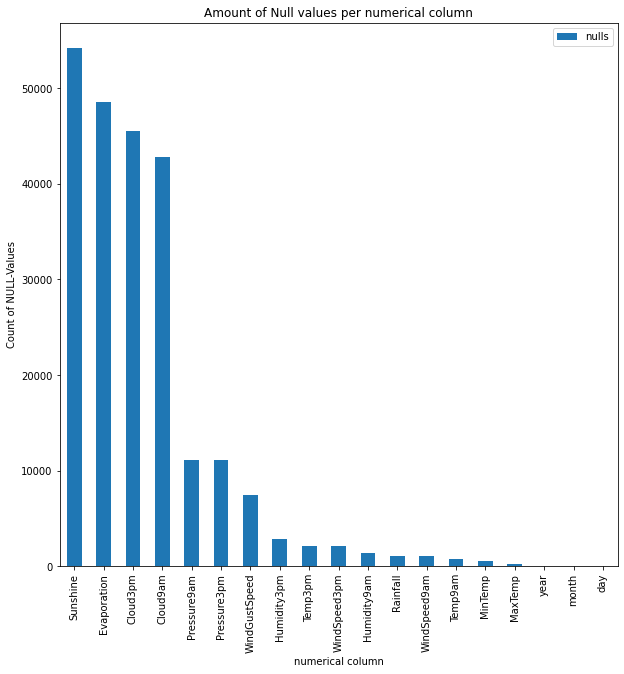

In [188]:
num_null_df.plot(kind='bar', figsize=(10, 10))
plt.title('Amount of Null values per numerical column')
plt.suptitle('')
plt.xlabel('numerical column')
plt.ylabel('Count of NULL-Values')
plt.savefig('exports/02-null-values-per-col-num.png')